In [110]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [111]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv") 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


**EDA**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Calories', ylabel='Count'>

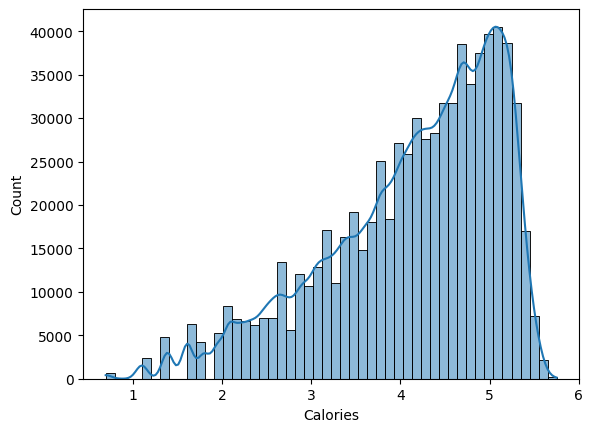

In [112]:
sns.histplot(np.log1p(train['Calories']), bins=50, kde=True)

In [113]:
train['Sex'] = train['Sex'].map({'female': 0, 'male': 1})
test['Sex'] = test['Sex'].map({'female': 0, 'male': 1})

<Axes: >

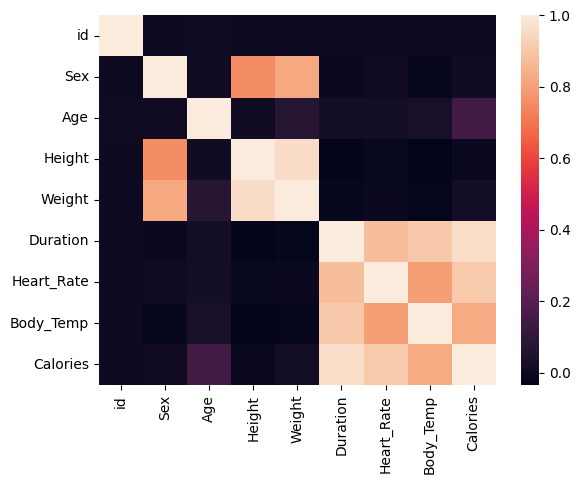

In [114]:
sns.heatmap(train.corr())

**Initial Data Cleaning**

In [115]:
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

In [116]:
train.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [117]:
train[train.duplicated()]

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
11643,0,54,161.0,61.0,14.0,95.0,40.3,76.0
18100,0,54,161.0,61.0,9.0,88.0,39.7,42.0
22070,1,51,187.0,94.0,3.0,81.0,38.8,10.0
26664,0,67,169.0,69.0,24.0,104.0,40.7,161.0
31062,0,40,161.0,58.0,14.0,90.0,40.4,64.0
...,...,...,...,...,...,...,...,...
749584,0,39,161.0,61.0,13.0,99.0,40.3,74.0
749823,0,29,173.0,68.0,14.0,95.0,40.2,67.0
749852,1,21,187.0,90.0,9.0,91.0,39.7,30.0
749889,1,40,191.0,88.0,5.0,86.0,39.0,18.0


Thoughts: Duplicated rows should not be deleted in this dataset, because each row represent a different individual, and there exist the possibility that their records duplicate. Duplicated records are still meaningful data.

In [118]:
train.drop_duplicates(inplace=True)

**Feature Engineering**

In [119]:
train['BMI'] = train['Weight'] / (train['Height'] / 100) ** 2
test['BMI'] = test['Weight'] / (test['Height'] / 100) ** 2

In [120]:
train['HR_Duration'] = train['Heart_Rate'] * train['Duration']
test['HR_Duration'] = test['Heart_Rate'] * test['Duration']

In [121]:
train['Temp_Duration'] = train['Body_Temp'] * train['Duration']
test['Temp_Duration'] = test['Body_Temp'] * test['Duration']

In [122]:
age_bins = [0, 20, 30, 40, 50, 60, 100]
train['Age_Group'] = pd.cut(train['Age'], bins=age_bins, labels=False)
test['Age_Group'] = pd.cut(test['Age'], bins=age_bins, labels=False)

cols_to_norm = ['Heart_Rate', 'Body_Temp']

for col in cols_to_norm:
    train[col + '_z'] = train.groupby('Age_Group')[col].transform(lambda x: (x - x.mean()) / x.std())

for col in cols_to_norm:
    test[col + '_z'] = test.groupby('Age_Group')[col].transform(lambda x: (x - x.mean()) / x.std())

In [123]:
train['Effort'] = train['Weight'] * train['Duration']
test['Effort'] = test['Weight'] * test['Duration']

In [124]:
train['temp_diff'] = train['Body_Temp'] - 37.0
test['temp_diff'] = test['Body_Temp'] - 37.0

In [143]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# Features and target
features = train.drop(columns=['Calories']).values
target = train['Calories'].values.reshape(-1, 1)

# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Create dataset and split
dataset = TensorDataset(X_tensor, y_tensor)
train_set, val_set = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

In [144]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [146]:
model = MLP(input_dim=X_tensor.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Early stopping setup
best_val_loss = float('inf')
patience = 5
counter = 0

# Training loop
for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in val_loader) / len(val_loader)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}. Best val loss: {best_val_loss:.4f}")
            break

Epoch 0: Val Loss = 0.0034
Epoch 10: Val Loss = 0.0034
Early stopping at epoch 12. Best val loss: 0.0033


In [148]:
X_test_scaled = scaler_X.transform(test)  # Assuming test contains only features
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [149]:
model.eval()
with torch.no_grad():
    y_test_pred_scaled = model(X_test_tensor).numpy()

In [150]:
y_test_pred_scaled

array([[-0.9737558 ],
       [ 0.3216958 ],
       [-0.02708749],
       ...,
       [-0.24122715],
       [ 1.2927632 ],
       [-0.19489616]], dtype=float32)

In [151]:
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_pred

array([[ 27.604155],
       [108.43776 ],
       [ 86.67438 ],
       ...,
       [ 73.312485],
       [169.03044 ],
       [ 76.20345 ]], dtype=float32)

In [154]:
test1 = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv") 


In [156]:
submission = pd.DataFrame({
    "id": test1['id'],
    "prediction": y_test_pred.flatten()
})

submission.to_csv('submission2.csv', index=False)